In [1]:
# Data-handling libraries
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Network libraries
import networkx as nx
import netwulf as nw

# Import utils
from network_utils import *

In [2]:
# Load formatted book (dict of chapters with list of lists of pages and sentences)
with open("1.Dataset_files/Books_formatted/Book1.pkl","rb") as f:
    book = pkl.load(f)

print(f" Number of chapters: {len(book)}, number of pages: {sum([len(chapter) for chapter in book.values()])}, number of sentences: {sum([sum([len(page) for page in chapter]) for chapter in book.values()])}")

# Load characters wiki
character_df = pd.read_csv("1.Dataset_files/CharacterWikis_clean.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]
character_df.Tokens = [eval(t) for t in character_df.Tokens]

# dict so we have all nodes (list of dicts of all character names (str) and their aliases (list of str)))
characters = []
for i, char in enumerate(character_df.Aliases):

    characters.append({'name':character_df['Name'].iloc[i], 'aliases': char + [character_df['Name'].iloc[i]]})

print(f" Number of characters: {len(characters)}, number of aliases: {sum([len(char['aliases']) for char in characters])}")

 Number of chapters: 17, number of pages: 347, number of sentences: 4929
 Number of characters: 677, number of aliases: 2000


In [3]:
# Draw network
G = nx.Graph()

# Add nodes to graph
for character in tqdm(characters, desc='Adding character nodes to graph...'):
    character['sizes'] = get_node_size(character['aliases'], book)
    G.add_node(character['name'], sizes=character['sizes'], attr=character['aliases'])

# Add edges to graph
for i, char1 in enumerate(tqdm(characters, desc='Adding edges to graph...')):
    for j, char2 in enumerate(characters[i+1:]):
        edge_weight = get_edge_book_weight(char1['aliases'], char2['aliases'], book)
        if sum(edge_weight.values()) != 0:
            G.add_edge(char1['name'], char2['name'], weight=edge_weight)

Adding edges to graph...: 100%|██████████| 677/677 [03:31<00:00,  3.20it/s]


Small data-issue: The character lists do not seem to have been scraped correctly, so there are some dublicates in the characters, resulting in the following discrepancy:

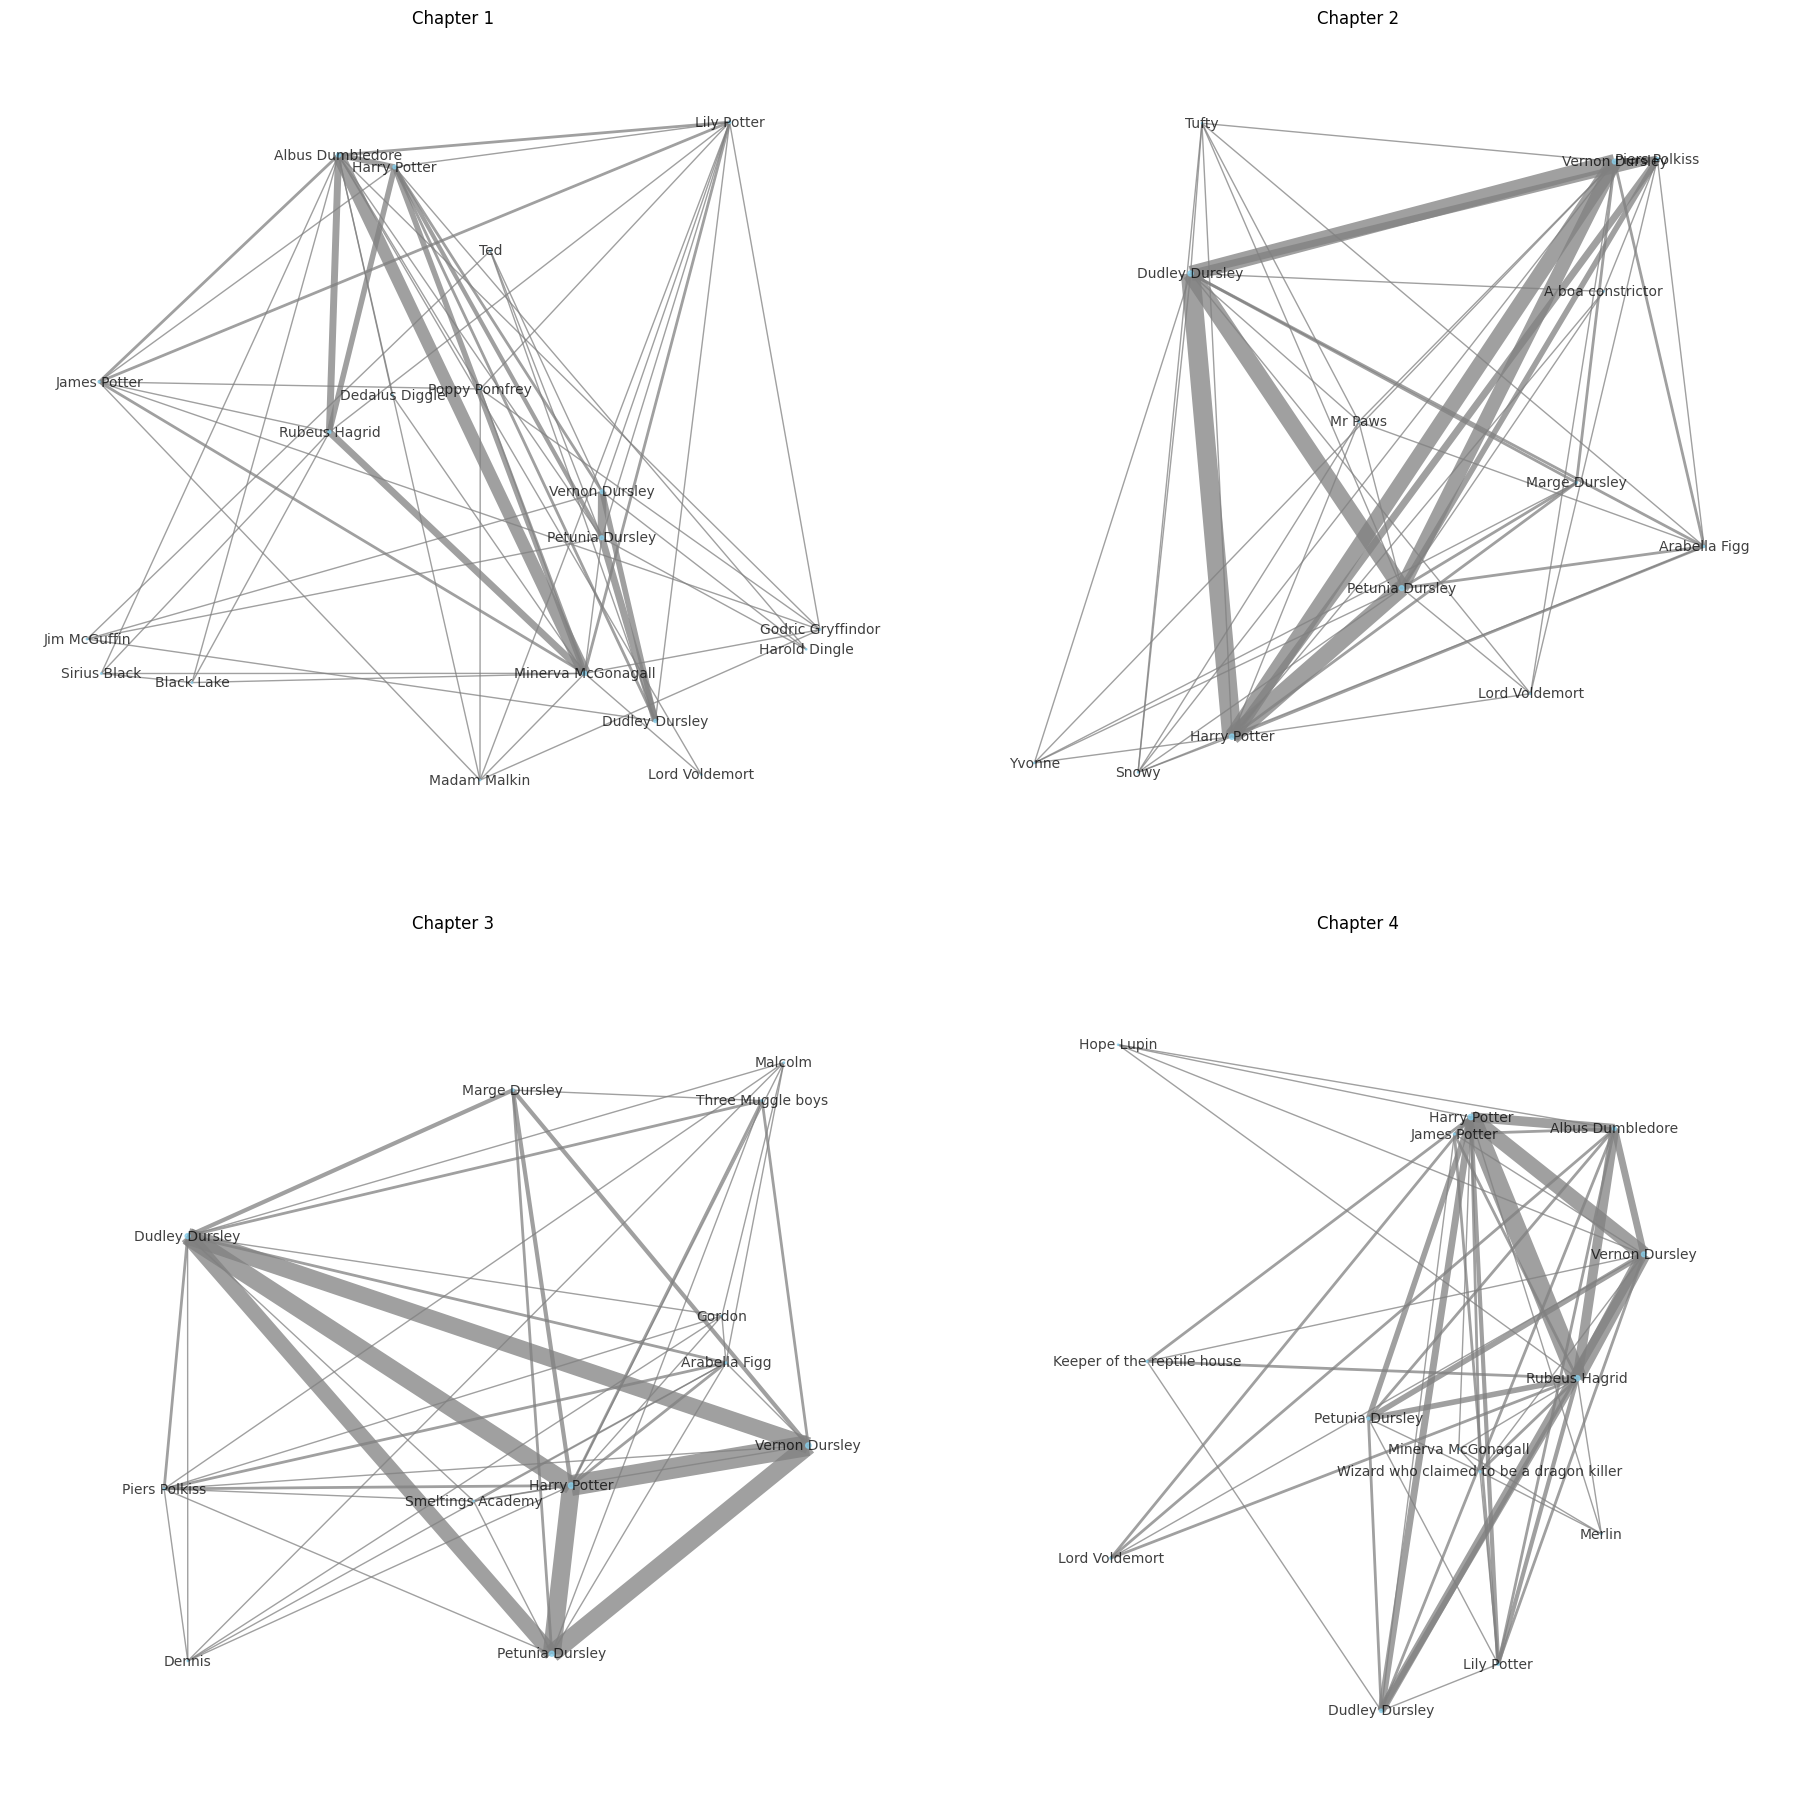

In [4]:
# draw network (random for starters)
# nw.visualize(G)
fig, axs = plt.subplots(2, 2, figsize=(18, 18), constrained_layout=True)

for chapternr in range(1,5):
    # Get node sizes
    node_sizes = [node[1]['sizes'][chapternr] for node in G.nodes.data()]

    # Get edge widths
    width = [edge[2]['weight'][chapternr] for edge in G.edges.data()]

    # Get labels
    labels = {}
    for node in G.nodes.data():
        if node[1]['sizes'][chapternr] != 0:
            labels.update({node[0]: node[0]})

    # plot
    nx.draw_random(G, node_size = node_sizes, width=width, edge_color = 'grey', node_color = 'skyblue', alpha = 0.75,
                   labels = labels, with_labels=True,
                   font_size=10, ax = axs[(chapternr-1)//2, (chapternr-1)%2])
    axs[(chapternr-1)//2, (chapternr-1)%2].set_title(f"Chapter {chapternr}")
plt.show()

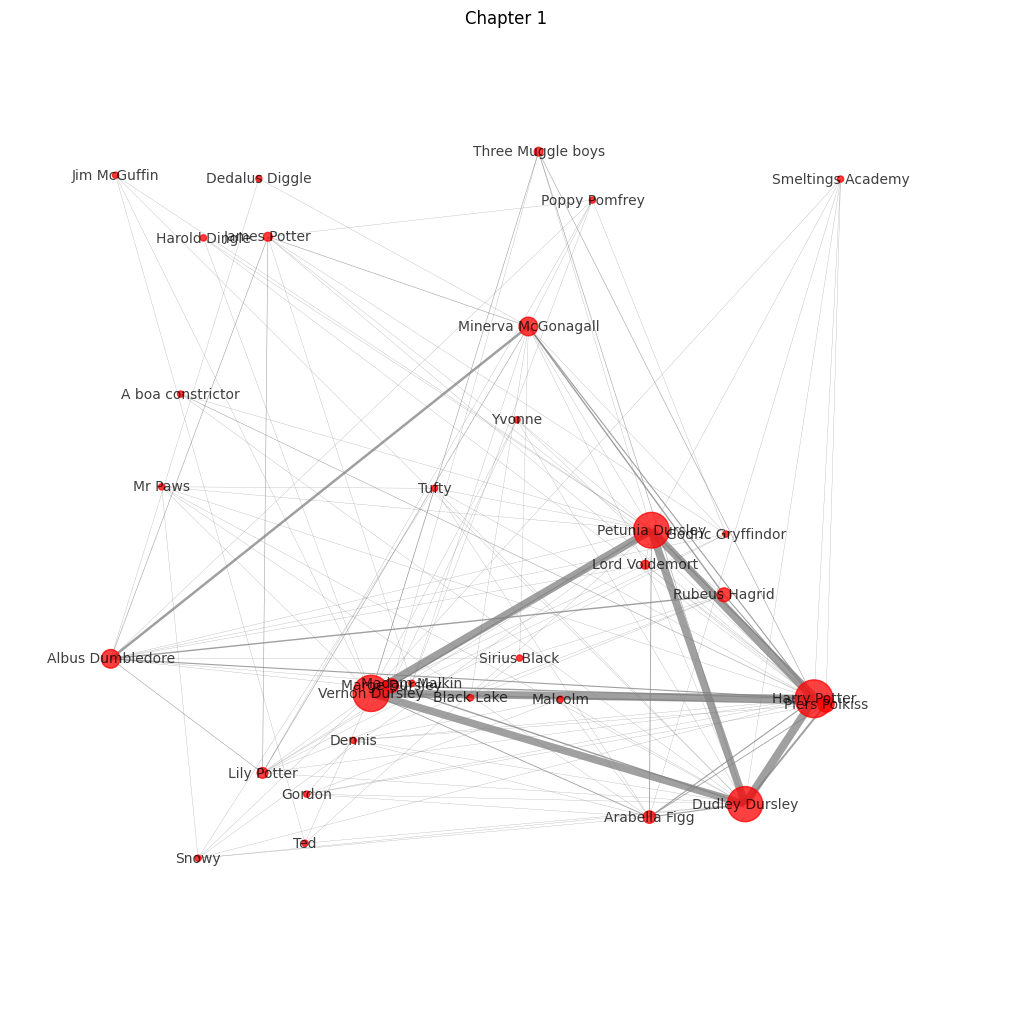

In [27]:
chapternr = [1,2,3]

# draw network
fig, axs = plt.subplots(1, figsize=(10, 10), constrained_layout=True)

node_sizes = [[node[1]['sizes'][nr] for node in G.nodes.data()] for nr in chapternr]
node_sizes = [sum(s)*20 for s in zip(*node_sizes)]

edge_weights = [[edge[2]['weight'][nr] for edge in G.edges.data()] for nr in chapternr]
edge_weights = [sum(w)*1/5 for w in zip(*edge_weights)]

labels = {}
for i, node in enumerate(G.nodes):
    if node_sizes[i] != 0:
        labels.update({node: node})

for i, node in enumerate(G.nodes):
    if node_sizes[i] != 0:
        labels.update({node: node})

# plot
nx.draw_random(G, node_size = node_sizes, width=edge_weights, edge_color = 'grey', node_color = 'red', alpha = 0.75,
                labels = labels, with_labels=True,
                font_size=10, ax = axs)



axs.set_title(f"Chapter 1")
plt.show()

In [8]:
# Save graph
pkl.dump(G, open('2.Network/Graphs/First_graph.pkl', 'wb'))

## TO DOs:
1. Fix the character lists with regards to the scraper, so we don't have dublicates
2. Check the above network code and see (1) if you can make it more efficient and (2) if you can make it more readable
3. Try to see if it makes more sense to get the networks based on: https://github.com/AlexDuvalinho/Dynamic-Graph-Networks
    3.1. As far as I can see, this is a more recent approach to the problem, so it might be worth a try
    3.2. The code seems to be very simple to get to work for our problem as we just need to clone the repo, put the books into the raw_text folder and run the code
    3.3. Huge plus is that the BERT_NER model has been fully trained and the weights can be downloaded from right here: https://onedrive.live.com/?authkey=%21AG6vMTjttNHJR5E&id=390AF7A51B5537E7%21776&cid=390AF7A51B5537E7&parId=root&parQt=sharedby&o=OneUp